In [85]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree
from sklearn.model_selection import GridSearchCV
import seaborn as sns

df = pd.read_csv("data/TOTAL_KSI.csv")

# PRE-PROCESSING

In [86]:
df['DATE'] = pd.to_datetime(df['DATE'], format='%m/%d/%Y %I:%M:%S %p', errors='coerce')
df = df.dropna(subset=['DATE'])
df['YEAR'] = df['DATE'].dt.year
df['MONTH'] = df['DATE'].dt.month
df['DAY'] = df['DATE'].dt.day
df['WEEKDAY'] = df['DATE'].dt.weekday

#cols_to_drop = [
#    "OBJECTID", "INDEX", "ACCNUM", "OFFSET",
#    "x", "y", "HOOD_158", "NEIGHBOURHOOD_158", "HOOD_140", "NEIGHBOURHOOD_140", "DISTRICT",
#    "FATAL_NO", "INVTYPE", 'INVAGE', "VEHTYPE",
#    "STREET1", "STREET2", "INITDIR", "PEDTYPE", "PEDACT", "MANOEUVER", "DRIVACT", "CYCLISTYPE",
#    "CYCACT", "DATE"
#]

cols_to_drop = [
    "DATE"
]

unknown_columns = [
    "PEDCOND", "CYCCOND", "DRIVCOND", "INJURY", "DIVISION", "TRAFFCTL",
    "INVTYPE", "VEHTYPE", 'OFFSET', "DISTRICT", "INVAGE", "NEIGHBOURHOOD_158", "NEIGHBOURHOOD_140"
]

other_columns = [
    "ROAD_CLASS", "ACCLOC", "VISIBILITY", "LIGHT", "RDSFCOND", "IMPACTYPE",
    "STREET1", "STREET2", "INITDIR", "PEDTYPE", "PEDACT", "MANOEUVER", "DRIVACT",
    "CYCLISTYPE", "CYCACT"
]

boolean_columns = [
    "PEDESTRIAN", "CYCLIST", "AUTOMOBILE", "MOTORCYCLE", "TRUCK", "TRSN_CITY_VEH",
    "EMERG_VEH", "PASSENGER", "SPEEDING", "AG_DRIV", "REDLIGHT", "ALCOHOL",
    "DISABILITY",
]
#  "FATAL_NO"
cols_to_drop = [col for col in cols_to_drop if col in df.columns]
df.drop(columns=cols_to_drop, inplace=True)

df = df.dropna(subset=["ACCLASS"])

df.loc[df['HOOD_158'] == 'NSA', 'HOOD_158'] = 0
df.loc[df['HOOD_140'] == 'NSA', 'HOOD_140'] = 0


df.loc[df['ACCLASS'] == 'Property Damage O', 'INJURY'] = 'None'
df.loc[df['ACCLASS'] == 'Property Damage O', 'ACCLASS'] = 'Non-Fatal Injury'
df["TRAFFCTL"] = df["TRAFFCTL"].fillna("No_Control")


#unknown_columns = [ 'PEDCOND', 'CYCCOND', 'DRIVCOND', "INJURY", "DIVISION", "TRAFFCTL"]
#other_columns = ['ROAD_CLASS', 'ACCLOC', 'VISIBILITY', 'LIGHT', 'RDSFCOND', 'IMPACTYPE']
#boolean_columns = ['PEDESTRIAN', 'CYCLIST', 'AUTOMOBILE', 'MOTORCYCLE', 'TRUCK', 'TRSN_CITY_VEH', 'EMERG_VEH', 'PASSENGER', 'SPEEDING', 'AG_DRIV', 'REDLIGHT', 'ALCOHOL', 'DISABILITY']

df[other_columns] = df[other_columns].fillna("Other")
df[unknown_columns] = df[unknown_columns].fillna("Unknown")
df[boolean_columns] = df[boolean_columns].fillna("No")


In [87]:
# COLUMNS LABELING
le_dict = {}
columns_to_encode = unknown_columns + other_columns + boolean_columns + ['ACCLASS']
for col in columns_to_encode:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    le_dict[col] = le

In [88]:
df.dtypes

OBJECTID               int64
INDEX                  int64
ACCNUM               float64
TIME                   int64
STREET1                int32
STREET2                int32
OFFSET                 int32
ROAD_CLASS             int32
DISTRICT               int32
LATITUDE             float64
LONGITUDE            float64
ACCLOC                 int32
TRAFFCTL               int32
VISIBILITY             int32
LIGHT                  int32
RDSFCOND               int32
ACCLASS                int32
IMPACTYPE              int32
INVTYPE                int32
INVAGE                 int32
INJURY                 int32
FATAL_NO             float64
INITDIR                int32
VEHTYPE                int32
MANOEUVER              int32
DRIVACT                int32
DRIVCOND               int32
PEDTYPE                int32
PEDACT                 int32
PEDCOND                int32
CYCLISTYPE             int32
CYCACT                 int32
CYCCOND                int32
PEDESTRIAN             int32
CYCLIST       

In [89]:
pd.DataFrame(df)


,OBJECTID,INDEX,ACCNUM,TIME,STREET1,STREET2,OFFSET,ROAD_CLASS,DISTRICT,LATITUDE,...,NEIGHBOURHOOD_158,HOOD_140,NEIGHBOURHOOD_140,DIVISION,x,y,YEAR,MONTH,DAY,WEEKDAY
0,1,3389067,8.931840e+05,236,1920,1854,491,5,3,43.699595,...,151,60,135,15,635468.3685,4.839881e+06,2006,1,1,6
1,2,3389068,8.931840e+05,236,1920,1854,491,5,3,43.699595,...,151,60,135,15,635468.3685,4.839881e+06,2006,1,1,6
2,3,3389069,8.931840e+05,236,1920,1854,491,5,3,43.699595,...,151,60,135,15,635468.3685,4.839881e+06,2006,1,1,6
3,4,3389070,8.931840e+05,236,1920,1854,491,5,3,43.699595,...,151,60,135,15,635468.3685,4.839881e+06,2006,1,1,6
4,5,3389071,8.931840e+05,236,1920,1854,491,5,3,43.699595,...,151,60,135,15,635468.3685,4.839881e+06,2006,1,1,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18952,18953,81755037,3.002957e+09,2008,1440,897,491,5,4,43.772151,...,149,137,133,11,640724.2608,4.848051e+06,2023,12,26,1
18953,18954,81754165,3.002971e+09,1911,1001,985,491,8,3,43.650847,...,83,84,71,3,626456.7479,4.834288e+06,2023,12,28,3
18954,18955,81754166,3.002971e+09,1911,1001,985,491,8,3,43.650847,...,83,84,71,3,626456.7479,4.834288e+06,2023,12,28,3
18955,18956,81755104,3.002978e+09,1829,989,1674,491,4,2,43.700789,...,26,120,24,9,637763.5905,4.840060e+06,2023,12,29,4


# RANDOM FOREST MODEL

In [90]:

target = df["ACCLASS"]
features = df.drop(columns=["ACCLASS"])

X = features
y = target

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=37, stratify=y
)

#param_grid = {
#    'max_depth': [1, 2, 3, 4, 5, 15, 25, 35, 40, 45, 100, None],
#    'n_estimators': [10, 30, 50, 100],
#    'min_samples_leaf': [1, 2, 5, 10]
#}
param_grid = {
    'max_depth': [35],
    'n_estimators': [30, 50],
    'min_samples_leaf': [1, 2, 5]
}

rf = RandomForestClassifier(random_state=37)
grid_search = GridSearchCV(rf, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Retrieve the best model from grid search
best_rf = grid_search.best_estimator_
print("Best Parameters:", grid_search.best_params_)
print("Best CV Score:", grid_search.best_score_)

# Evaluate on test data using the best estimator
y_pred = best_rf.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:")
print(classification_report(y_test, y_pred))

Best Parameters: {'max_depth': 35, 'min_samples_leaf': 1, 'n_estimators': 50}
Best CV Score: 0.9466833929215438
Accuracy: 0.9516775691074066
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.66      0.79       667
           1       0.95      1.00      0.97      4072

    accuracy                           0.95      4739
   macro avg       0.97      0.83      0.88      4739
weighted avg       0.95      0.95      0.95      4739



# MODEL EVALUATION

In [91]:
y_pred = best_rf.predict(X_test)
print("Classification Report:")
print(classification_report(y_test, y_pred))
print("Accuracy Score:")
print(accuracy_score(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.66      0.79       667
           1       0.95      1.00      0.97      4072

    accuracy                           0.95      4739
   macro avg       0.97      0.83      0.88      4739
weighted avg       0.95      0.95      0.95      4739

Accuracy Score:
0.9516775691074066


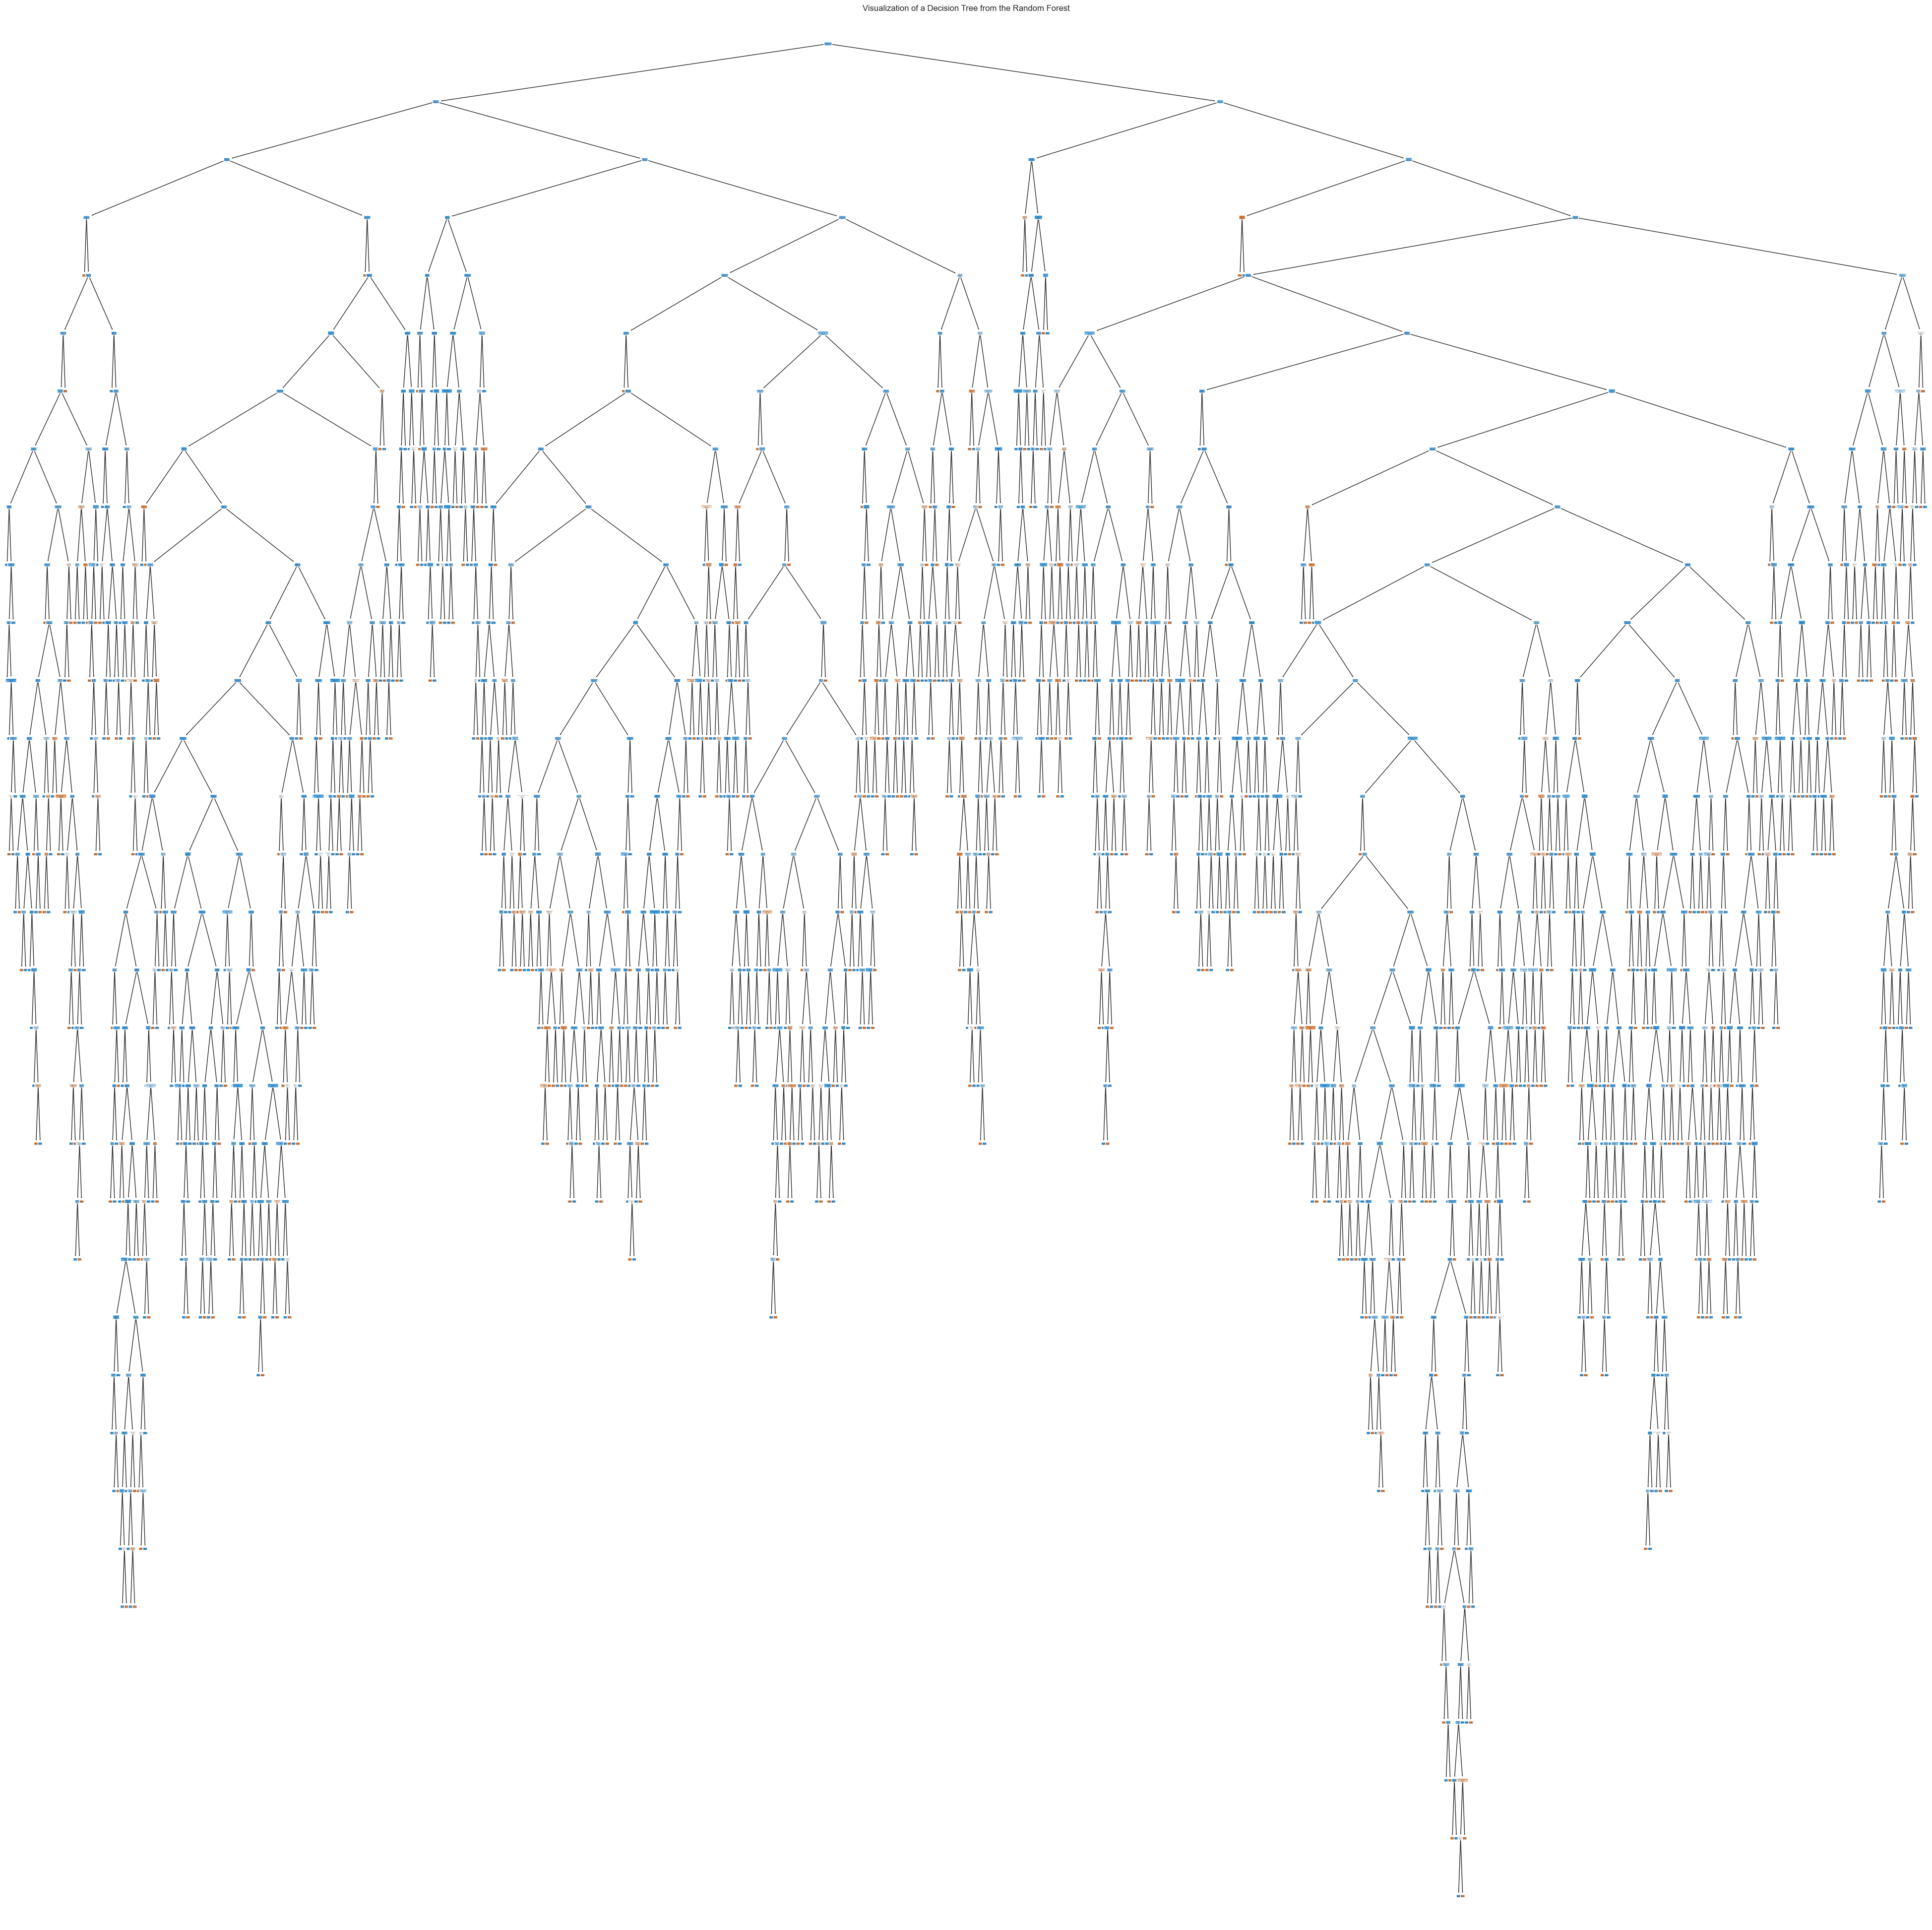

In [92]:
estimator = best_rf.estimators_[1]

plt.figure(figsize=(50, 50))
plot_tree(
    estimator,
    feature_names=X.columns,
    class_names=["0", "1"],
    filled=True,
    rounded=True,
    precision=2
)
plt.title("Visualization of a Decision Tree from the Random Forest")
plt.show()

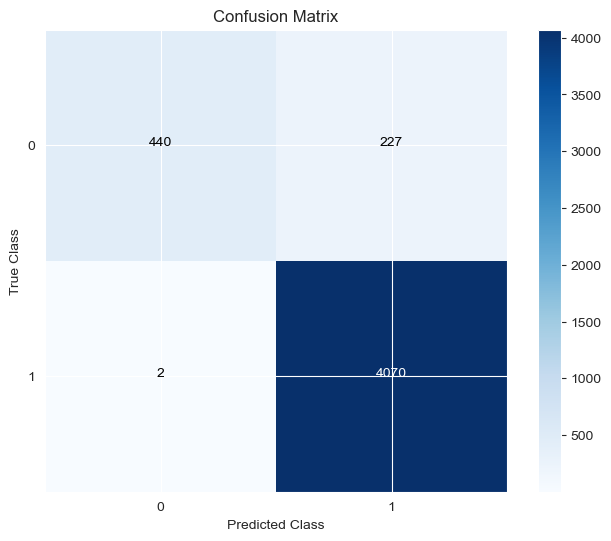

In [93]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.colorbar()
tick_marks = range(len(set(y_test)))
plt.xticks(tick_marks, tick_marks)
plt.yticks(tick_marks, tick_marks)

thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
                 
plt.ylabel('True Class')
plt.xlabel('Predicted Class')
plt.show()


In [104]:
correlation_matrix = df.corr()

plt.figure(figsize=(100, 100))
plt.imshow(correlation_matrix, cmap='coolwarm', interpolation='none')

# Adjust colorbar font size
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=14)

# Increase tick label font size on x and y axes
plt.xticks(range(len(correlation_matrix.columns)), correlation_matrix.columns, rotation=90, fontsize=40)
plt.yticks(range(len(correlation_matrix.columns)), correlation_matrix.columns, fontsize=40)

# Increase title font size
plt.title("Correlation Matrix", fontsize=30)

plt.show()

# Calculate the correlation matrix
correlation_matrix = df.corr()

# Save the correlation matrix to a CSV file named "correlation_matrix.csv"
correlation_matrix.to_csv("correlation_matrix.csv")



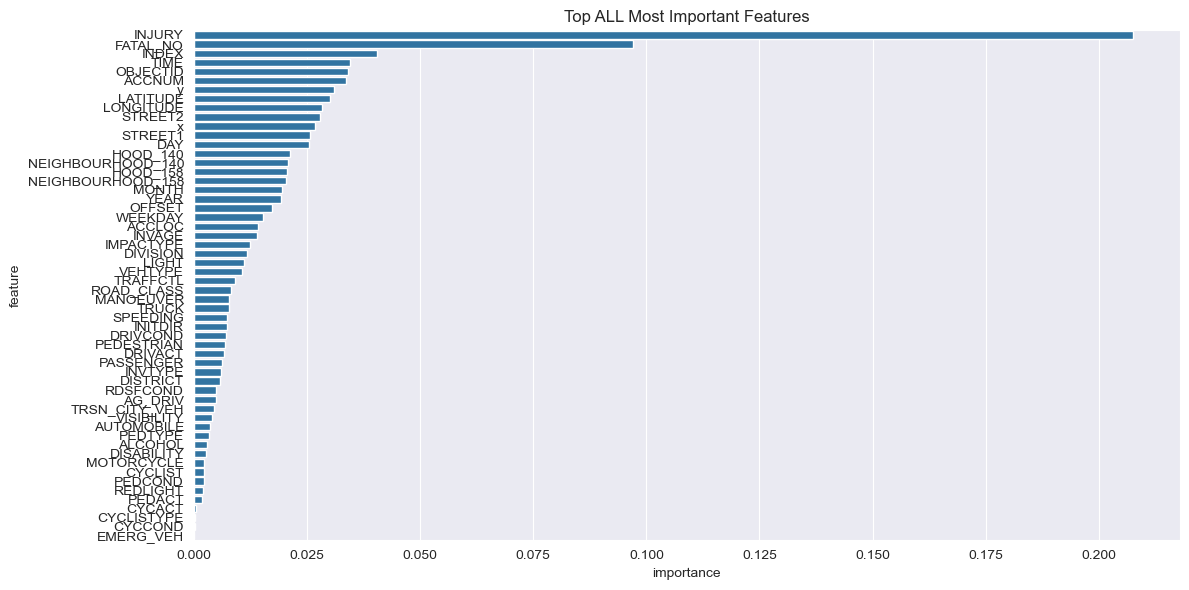

In [99]:
# Get feature importance
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': best_rf.feature_importances_
}).sort_values('importance', ascending=False)

# Save feature importance plot
plt.figure(figsize=(12, 6))
sns.barplot(data=feature_importance.head(200), x='importance', y='feature')
plt.title('Top ALL Most Important Features')
plt.tight_layout()
plt.show()

<Figure size 1500x1000 with 0 Axes>

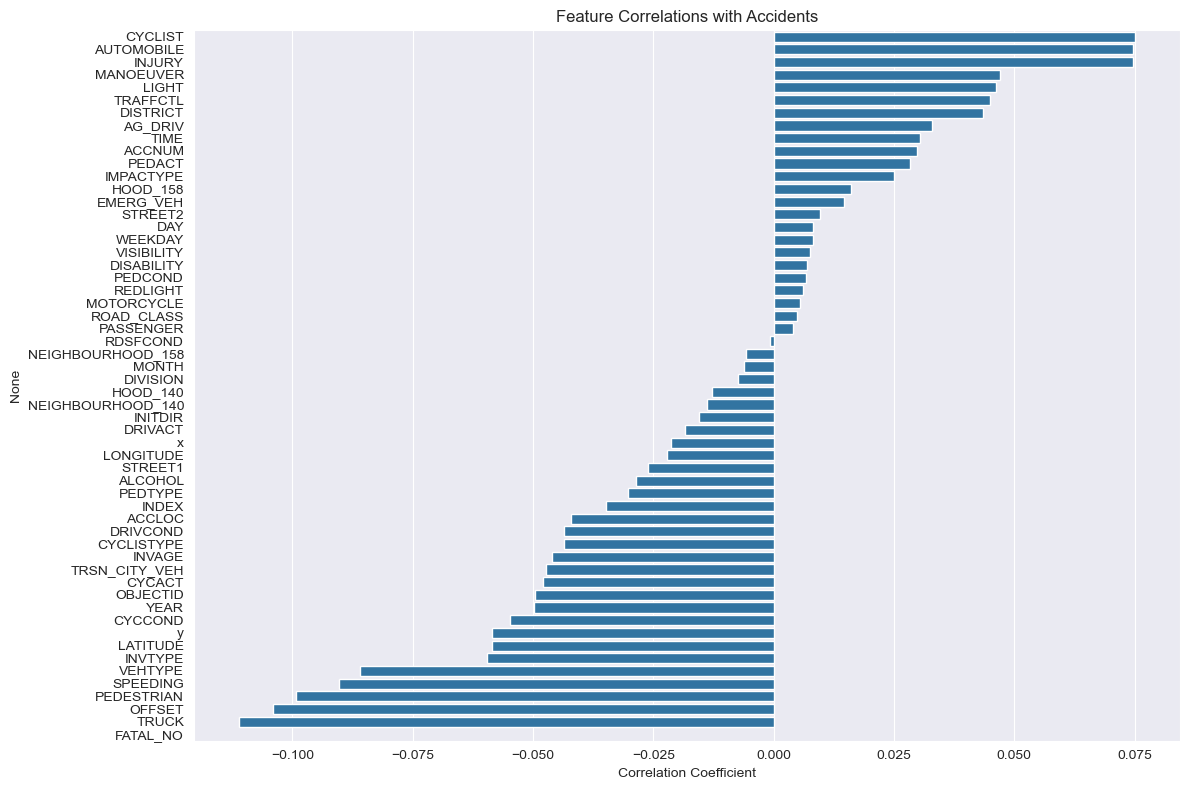

In [96]:

# Create specific correlation plot with target
plt.figure(figsize=(15, 10))
target_corr = correlation_matrix['ACCLASS'].sort_values(ascending=False)
target_corr = target_corr.drop('ACCLASS')

plt.figure(figsize=(12, 8))
sns.barplot(x=target_corr.values, y=target_corr.index)
plt.title('Feature Correlations with Accidents')
plt.xlabel('Correlation Coefficient')
plt.tight_layout()
plt.show()

In [97]:
plt.figure(figsize=(24, 20))
sns.heatmap(
    correlations.iloc[start_idx:end_idx, start_idx:end_idx],
    annot=True,
    cmap='coolwarm',
    center=0,
    fmt='.2f',
    square=True
)
plt.title(f'Full Correlation Matrix Part {i+1}')
plt.tight_layout()
plt.savefig(f'insights/correlation/full_correlation_matrix_{i+1}.png',
           dpi=300, bbox_inches='tight')
plt.close()

NameError: name 'correlations' is not defined

<Figure size 2400x2000 with 0 Axes>

In [ ]:
plt.figure(figsize=(8, 6))
plt.hist(df['YEAR'], bins=20, edgecolor='black')
plt.title("Year Distribution")
plt.xlabel("Year")
plt.ylabel("Frequency")
plt.show()

In [ ]:
plt.figure(figsize=(8, 6))
plt.scatter(df['MONTH'], df['DAY'], alpha=0.005)
plt.title("Scatter Plot: Month vs Day")
plt.xlabel("Month")
plt.ylabel("Day")
plt.show()